# NBA Re-Scoring

In [92]:
#%pip install -r requirements.txt

In [145]:
%load_ext autoreload
%autoreload 1
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import utils as u

## Introduction

On February 7th, 2001, Baron Davis, with 0.7 seconds left on the clock and facing full coverage from Lindsey Hunter, [makes a shot from 89 feet](https://www.youtube.com/watch?v=y8HiuYqn7kc). This is the longest made shot in NBA history, and given that an NBA court is 94 feet in length, we may not see a longer shot. Most incredibly, [if you believe the lore](https://www.youtube.com/watch?v=ndmBCqds_gc), Davis said he called his shot.

For his effort, Baron Davis and the Charlotte Hornets were awarded 3 points.

That cannot be fair, right?

## Loading Data

Thank you to https://github.com/DomSamangy/NBA_Shots_04_25 for providing the data, as querying NBA or ESPN data sources is heavily rate-limited or undocumented.

This CSV file contains detailed information on every attempted shot in the NBA from 2004 to 2025.

In [94]:
df = pl.read_csv('NBA_2004_2025_Shots.csv')
print(f"# Rows: {len(df)}")
print(f"Shape: {df.shape}")
df = df.drop(["SEASON_2", "EVENT_TYPE", "ACTION_TYPE", "BASIC_ZONE", "ZONE_NAME", "ZONE_ABB", "ZONE_RANGE", "QUARTER", "MINS_LEFT", "SECS_LEFT"])
print(df.head)

# Rows: 4443714
Shape: (4443714, 24)
<bound method DataFrame.head of shape: (4_443_714, 14)
┌──────────┬────────────┬──────────────┬───────────┬───┬─────────────┬───────┬───────┬─────────────┐
│ SEASON_1 ┆ TEAM_ID    ┆ TEAM_NAME    ┆ PLAYER_ID ┆ … ┆ SHOT_TYPE   ┆ LOC_X ┆ LOC_Y ┆ SHOT_DISTAN │
│ ---      ┆ ---        ┆ ---          ┆ ---       ┆   ┆ ---         ┆ ---   ┆ ---   ┆ CE          │
│ i64      ┆ i64        ┆ str          ┆ i64       ┆   ┆ str         ┆ f64   ┆ f64   ┆ ---         │
│          ┆            ┆              ┆           ┆   ┆             ┆       ┆       ┆ i64         │
╞══════════╪════════════╪══════════════╪═══════════╪═══╪═════════════╪═══════╪═══════╪═════════════╡
│ 2025     ┆ 1610612737 ┆ Atlanta      ┆ 1642258   ┆ … ┆ 3PT Field   ┆ 16.8  ┆ 25.75 ┆ 26          │
│          ┆            ┆ Hawks        ┆           ┆   ┆ Goal        ┆       ┆       ┆             │
│ 2025     ┆ 1610612737 ┆ Atlanta      ┆ 1630552   ┆ … ┆ 2PT Field   ┆ 13.6  ┆ 5.15  ┆ 13          │

## Visualizing Shots

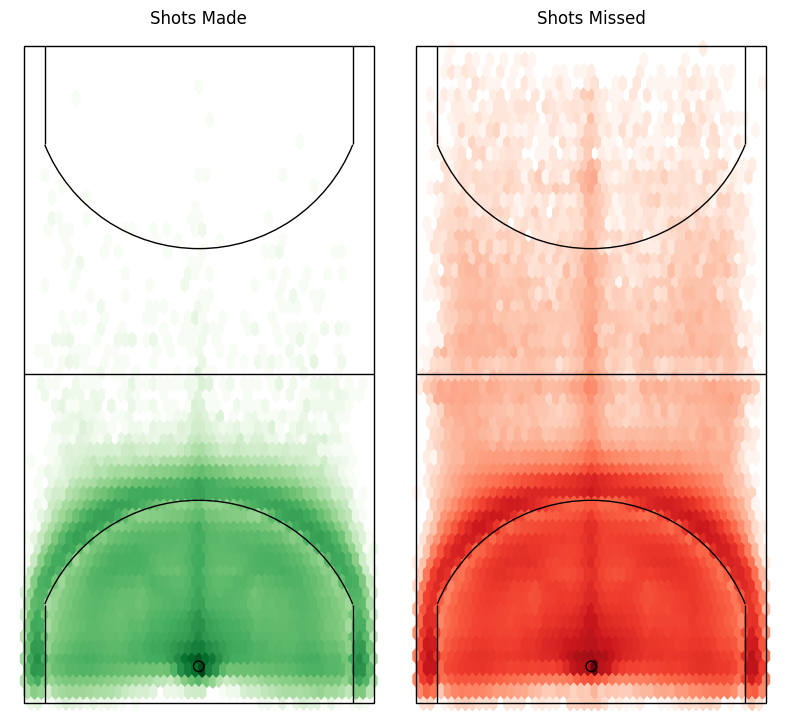

In [ ]:
u.made_missed_shots_density(df)

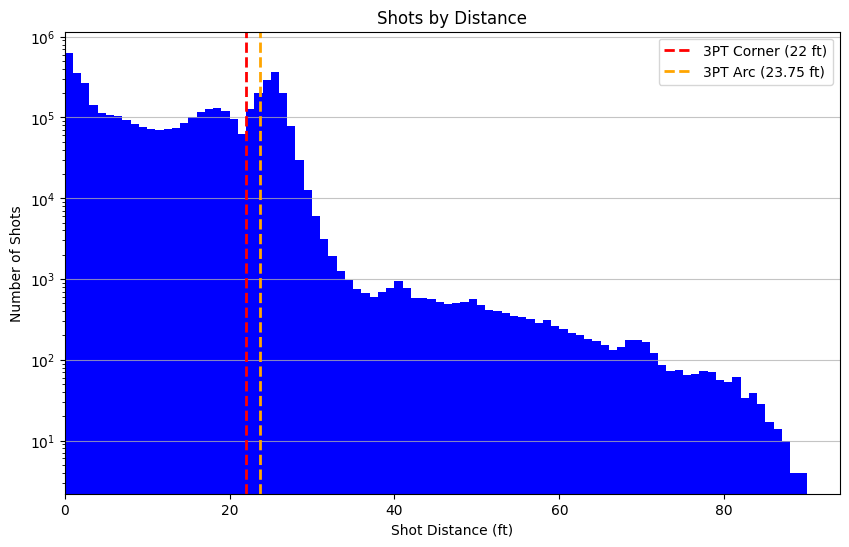

In [176]:
u.plot_shots_by_distance(df)

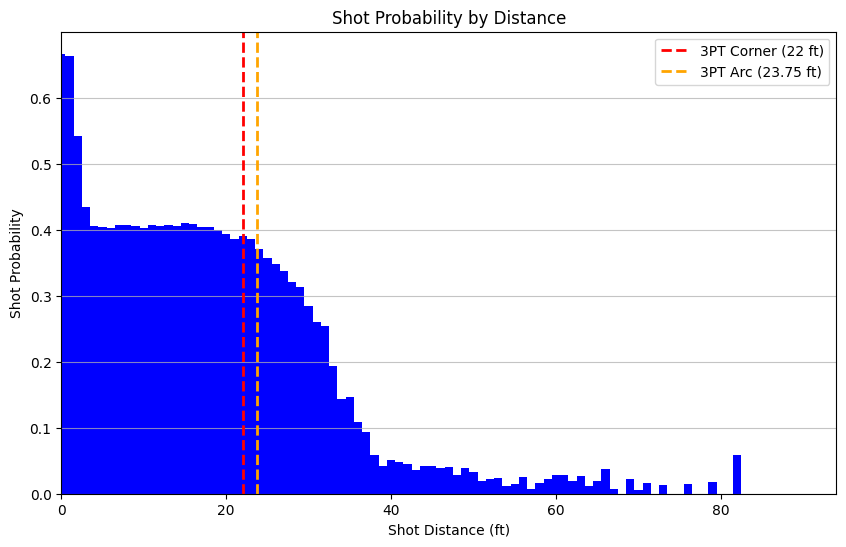

In [175]:
u.plot_shot_prob_by_distance(df)

## Expected Value

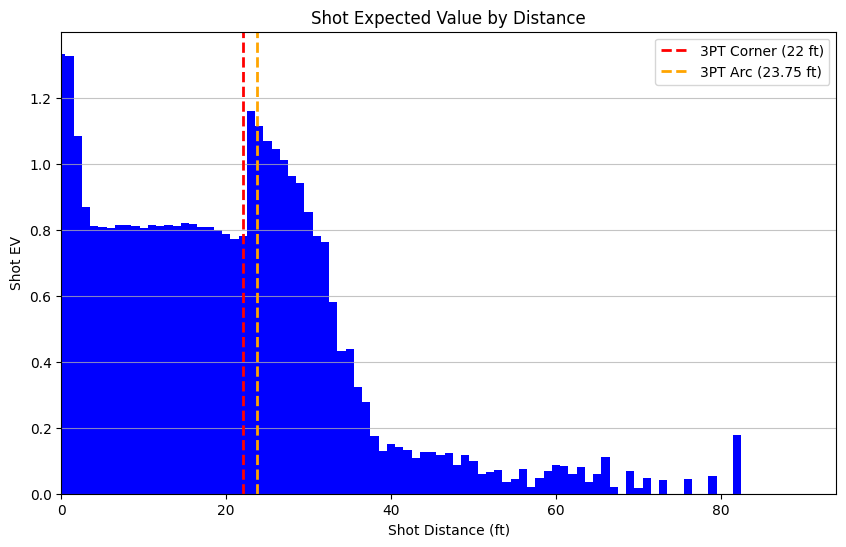

In [178]:
u.plot_shot_EV_by_distance(df)

In [185]:
shots_worth_2 = df.filter((df["SHOT_TYPE"] == "2PT Field Goal"))
shots_worth_3 = df.filter((df["SHOT_TYPE"] == "3PT Field Goal"))
full_prb_2pts = len(shots_worth_2.filter(shots_worth_2["SHOT_MADE"] == True)) / len(shots_worth_2)
full_prb_3pts = len(shots_worth_3.filter(shots_worth_3["SHOT_MADE"] == True)) / len(shots_worth_3)
full_EV_2pts = full_prb_2pts * 2
full_EV_3pts = full_prb_3pts * 3
print(f"Expected Value from 2pt Shot: {full_EV_2pts:.4f}")
print(f"Expected Value from 3pt Shot: {full_EV_3pts:.4f}")

Expected Value from 2pt Shot: 0.9984
Expected Value from 3pt Shot: 1.0749


In [191]:
close_2_EV = u.calculate_shot_probability(df, 0, 3) * 2
midrange_2_EV = u.calculate_shot_probability(df, 5, 21) * 2
close_3_EV = u.calculate_shot_probability(df, 24, 24) * 3
print(f"Close 2pt EV: {close_2_EV:.4f}")
print(f"Midrange 2pt EV: {midrange_2_EV:.4f}")
print(f"Close 3pt EV: {close_3_EV:.4f}")

Close 2pt EV: 1.2358
Midrange 2pt EV: 0.8081
Close 3pt EV: 1.1138


The expected value of the typical NBA shot is around 1, peaking to around 1.2 close to each line.

Considering this, we can add a new point line at a specific distance, referencing these expected values, such that distance chosen makes the shot as "worth taking" as we like. 

[Northwestern Sports Analytics Group](https://sites.northwestern.edu/nusportsanalytics/2020/12/16/nba-hypothetical-the-four-point-line/) underwent a similar analysis, and determined that their suitable 4 point line would be at 30ft away from the rim, for an expected value of 0.693, justifying that this EV would not make the game center completely around the new 4pt line. 

For my experiment, I'm considering that to be not enough. I want each shot to be fairly rewarded, with a target expected value across the court of 1.

In [ ]:
# Checking the work for 4 point line
target_EV = 1
deserved_points = 4
best_diff = 999
best_dist = -1
for dist in range(0, 95):
    current_EV = u.calculate_shot_probability(df, dist, 200) * deserved_points
    diff = abs(current_EV - target_EV)
    if diff < best_diff:
        best_diff = diff
        best_dist = dist
print(f"Best Distance for {deserved_points} Point Line (Target EV {target_EV}): {best_dist}")

Best Distance for 4 Point Line (Target EV 1): 28


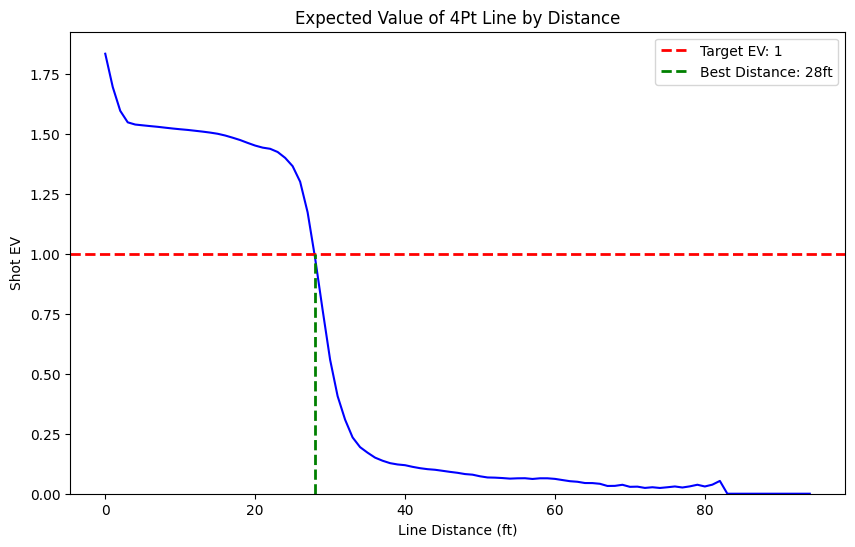

In [213]:
best_line_4pt_1EV = u.get_point_distance(df, 4, target_EV=1, graph_bool=True, print_bool=False)

For Baron Davis' Bucket from 89 Feet, what would be a fair reward?

We'll arbitrarily set the shooting line at 80 feet, as there are no makes from 89ft+ from the available database.

In [ ]:
# By hand calculating deserved points for shots over 80ft
eighty_num_shots = u.calculate_num_shots(df, 80, 200)
print(f"Number of shots from 80ft or more: {eighty_num_shots}")
eightyft_shot_prob = u.calculate_shot_probability(df, 80, 200)
print(f"Probability from 80ft: {eightyft_shot_prob*100:.4f}%")
targetEV = 1
eightyft_points = targetEV / eightyft_shot_prob
print(f"Deserved points for Target EV of {targetEV}: {eightyft_points}")

Number of shots from 80ft or more: 265
Probability from 80ft: 0.7547%
Deserved points for Target EV of 1: 132.5


Thus, the 132 point line.

Lets graph, for every possible distance, the most fair point value for an EV of 1.

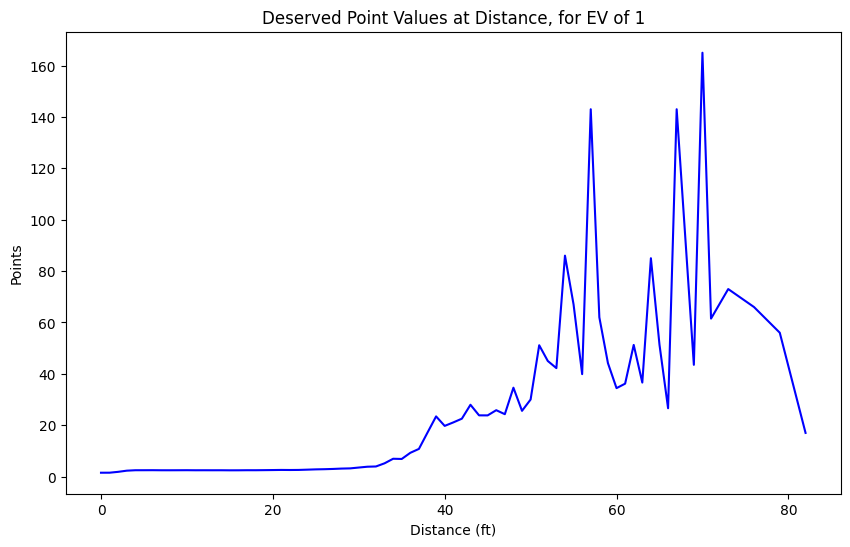

In [233]:
EV = 1
points_per_distance = {}
for dist in range(0,95):
    deserved_points = u.get_deserved_points(df, dist, dist, EV, False)
    if deserved_points > 0:
        points_per_distance[dist] = deserved_points
plt.figure(figsize=(10,6))
plt.plot(list(points_per_distance.keys()), list(points_per_distance.values()), color='b')
plt.title(f"Deserved Point Values at Distance, for EV of {EV}")
plt.xlabel("Distance (ft)")
plt.ylabel("Points")
plt.show()

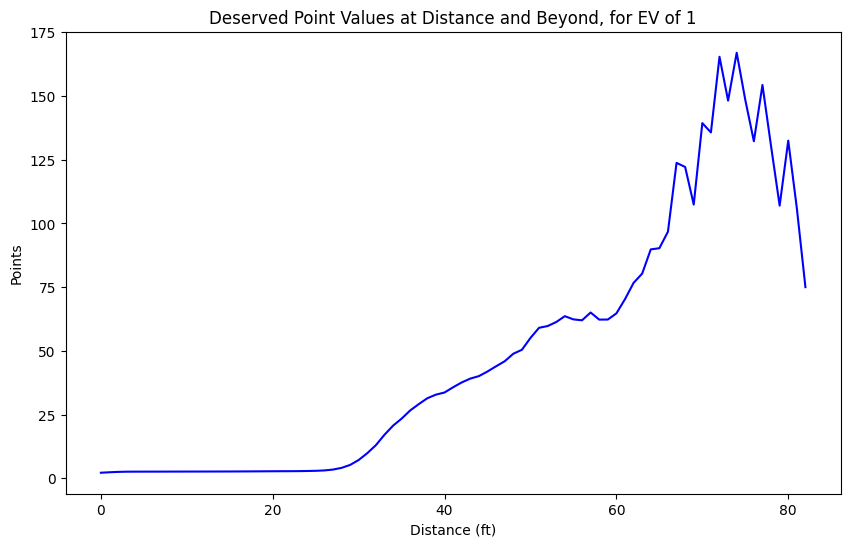

In [234]:
EV = 1
points_per_distance = {}
for dist in range(0,95):
    deserved_points = u.get_deserved_points(df, dist, 200, EV, False)
    if deserved_points > 0:
        points_per_distance[dist] = deserved_points
plt.figure(figsize=(10,6))
plt.plot(list(points_per_distance.keys()), list(points_per_distance.values()), color='b')
plt.title(f"Deserved Point Values at Distance and Beyond, for EV of {EV}")
plt.xlabel("Distance (ft)")
plt.ylabel("Points")
plt.show()

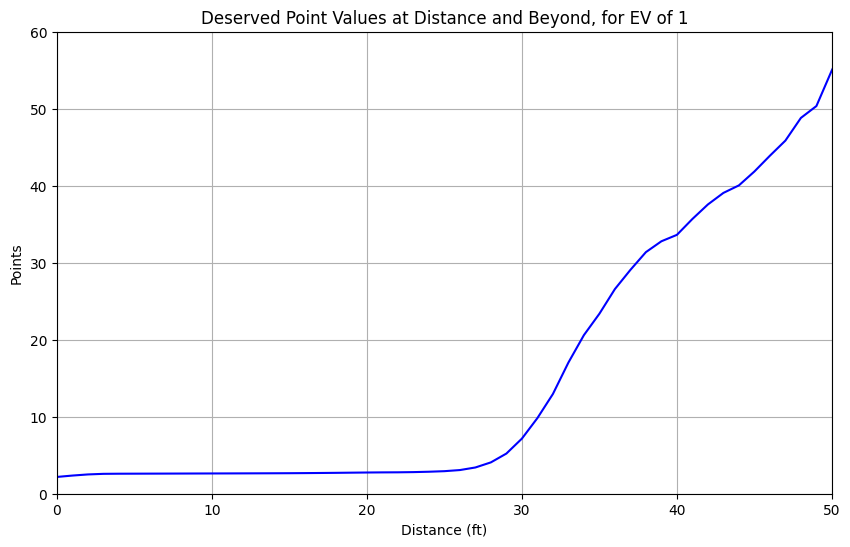

In [235]:
plt.figure(figsize=(10,6))
plt.plot(list(points_per_distance.keys()), list(points_per_distance.values()), color='b')
plt.title(f"Deserved Point Values at Distance and Beyond, for EV of {EV}")
plt.xlabel("Distance (ft)")
plt.ylabel("Points")
plt.xlim(0,50)
plt.ylim(0, points_per_distance[50]+5)
plt.grid(True)
plt.show()

## Implementing New Point Lines

In [ ]:
# TODO Choose new point lines arbitrarily (4pt line at 28ft, then xpt line at 50ft, then xpt line at 80ft?)
# TODO Draw new lines on NBA court diagram
# TODO Rescore Games